<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_multiple_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues



## Python Package Installation
* Install all the packages through FinRL library

In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-rf9vrpf8
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-rf9vrpf8
     |████████████████████████████████| 14.5MB 337kB/s 
     |████████████████████████████████| 9.5MB 34.8MB/s 
  Created wheel for finrl: filename=finrl-0.0.1-cp36-none-any.whl size=419400 sha256=28a91870e3881b49676a3528644d0b4d5d1bc3e64d403418a0cec27c3948ad44
  Stored in directory: /tmp/pip-ephem-wheel-cache-vwtslqv6/wheels/9c/19/bf/c644def96612df1ad42c94d5304966797eaa3221dffc5efe0b
Successfully built finrl
ERROR: tensorflow 1.15.4 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement cloudpickle==1.3, but you'll have cloudpickle 1.2.2 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: finrl 0.0.1 has 


Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

In [ ]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas','numpy', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow','pyfolio'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4
    !pip install git+https://github.com/quantopian/pyfolio


## Import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.environment import EnvSetup
from finrl.env.EnvMultipleStock_train import StockEnvTrain
from finrl.env.EnvMultipleStock_trade import StockEnvTrade
from finrl.model.models import DRLAgent


## Create folders

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

# Part 1: Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.

In [ ]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = config.END_DATE,
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.shape

(88680, 7)

In [ ]:
df.head()

,date,open,high,low,close,volume,tic
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,7.460152e+08,AAPL
1,2009-01-05,3.327500,3.435000,3.311071,2.890248,1.181608e+09,AAPL
2,2009-01-06,3.426786,3.470357,3.299643,2.842576,1.289310e+09,AAPL
3,2009-01-07,3.278929,3.303571,3.223572,2.781153,7.530488e+08,AAPL
4,2009-01-08,3.229643,3.326786,3.215714,2.832797,6.735008e+08,AAPL


# Part 2: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [ ]:
df = FeatureEngineer(df,feature_number=5,
                        use_technical_indicator=True,
                        use_turbulence=True).preprocess_data()

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
df.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200.0,AAPL,0.0,100.0,66.666667,100.0,0.0
1,2009-01-02,18.570000,19.520000,18.400000,15.800624,10955700.0,AXP,0.0,100.0,66.666667,100.0,0.0
2,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA,0.0,100.0,66.666667,100.0,0.0
3,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT,0.0,100.0,66.666667,100.0,0.0
4,2009-01-02,16.410000,17.000000,16.250000,12.786087,40980600.0,CSCO,0.0,100.0,66.666667,100.0,0.0


# Part 3: Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a Markov Decision Process (MDP) problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2018-12-31
## Trade data split: 2019-01-01 to 2020-09-30

In [ ]:
train = data_split(df, config.START_DATE,config.START_TRADE_DATE)
trade = data_split(df,config.START_TRADE_DATE,config.END_DATE)


In [ ]:
train.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200.0,AAPL,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,18.570000,19.520000,18.400000,15.800624,10955700.0,AXP,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,42.799999,45.560001,42.779999,33.680935,7010200.0,BA,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,44.910000,46.980000,44.709999,32.514400,7117200.0,CAT,0.0,100.0,66.666667,100.0,0.0
0,2009-01-02,16.410000,17.000000,16.250000,12.786087,40980600.0,CSCO,0.0,100.0,66.666667,100.0,0.0


In [ ]:
trade.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2019-01-02,38.722500,39.712502,38.557499,38.249401,148158800.0,AAPL,-2.003499,37.867367,-91.588048,42.250808,119.879175
0,2019-01-02,93.910004,96.269997,93.769997,92.643311,4175400.0,AXP,-3.426008,41.204982,-97.742269,26.709417,119.879175
0,2019-01-02,316.190002,323.950012,313.709991,314.645142,3292200.0,BA,-5.550592,47.010000,-21.712382,13.611972,119.879175
0,2019-01-02,124.029999,127.879997,123.000000,119.302582,4783200.0,CAT,-0.686759,48.229089,-5.091209,0.873482,119.879175
0,2019-01-02,42.279999,43.200001,42.209999,40.382099,23833500.0,CSCO,-0.960061,44.872557,-87.496850,29.529377,119.879175


In [ ]:
env_setup = EnvSetup(stock_dim = len(train.tic.unique()))

## Environment for Training



In [ ]:
env_train = env_setup.create_env_training(data = train,
                                          env_class = StockEnvTrain)

## Environment for Trading



In [ ]:
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                         env_class = StockEnvTrade) 

# Part 4: Implement DRL Algorithms
The implementation of the DRL algorithms are based on OpenAI Baselines and Stable Baselines. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.

In [ ]:
agent = DRLAgent(env = env_train)

## Model training: A2C


In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
a2c_params_tuning = {'n_steps':5, 
			  'ent_coef':0.005, 
			  'learning_rate':0.0007,
			  'verbose':0,
			  'timesteps':100000}
model_a2c = agent.train_A2C(model_name = "A2C_{}".format(now), a2c_params = a2c_params_tuning)

==============Model Training===========




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


begin_total_asset:1000000
end_total_asset:3116956.442147473
total_reward:2116956.442147473
total_cost:  266652.2422061698
total_trades:  73470
Sharpe:  0.894724360677458
begin_total_asset:1000000
end_total_asset:2584409.978516255
total_reward:1584409.978516255
total_cost:  209008.53001547075
total_trades:  70212
Sharpe:  0.6871213923542917
begin_total_asset:1000000
end_total_asset:3651986.177180177
total_reward:2651986.177180177
total_cost:  146702.12232089904
total_trades:  62596
Sharpe:  0.9108636334858738
begin_total_asset:1000000
end_total_asset:4323004.131889863
total_reward:3323004.131889863

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be the 99% quantile of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [ ]:
insample_turbulence = train.drop_duplicates(subset=['date'])

In [ ]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean       75.936147
std        38.178004
min         0.000000
25%        58.034359
50%        74.014979
75%        96.948929
max       230.256682
Name: turbulence, dtype: float64

In [ ]:
insample_turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [ ]:
insample_turbulence_threshold

230.25668159719464

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                         env_class = StockEnvTrade,
                                         turbulence_threshold=250) 

df_account_value = DRLAgent.DRL_prediction(model=model_a2c,
                        test_data = trade,
                        test_env = env_trade,
                        test_obs = obs_trade)

previous_total_asset:1000000
end_total_asset:1459662.531339552
total_reward:459662.531339552
total_cost:  18608.82601461945
total trades:  9903
Sharpe:  1.2163708048963664


In [ ]:
df_account_value.shape

(440, 2)

In [ ]:
df_account_value.head()

,date,account_value
0,2019-01-02,1.000000e+06
1,2019-01-02,9.968992e+05
2,2019-01-03,1.004212e+06
3,2019-01-04,1.005609e+06
4,2019-01-07,1.008352e+06


In [ ]:
df_account_value.tail()

,date,account_value
435,2020-09-22,1.421838e+06
436,2020-09-23,1.427396e+06
437,2020-09-24,1.446008e+06
438,2020-09-25,1.467663e+06
439,2020-09-28,1.459663e+06


# Part 5: Backtest Our Strategy
For simplicity purposes, in the article, we just calculate the Sharpe ratio and the annual return manually.

In [ ]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['date'] = pd.to_datetime(strategy_ret['date'])
    strategy_ret.set_index('date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

## Dow Jones Industrial Average


In [ ]:
dji = YahooDownloader(start_date = "2019-01-02",
                     end_date = "2020-10-30",
                     ticker_list = ['^DJI']).fetch_data()
dji['daily_return']=dji['close'].pct_change(1)
dow_strat = backtest_strat(dji)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (462, 7)


In [ ]:
dji.head()

,date,open,high,low,close,volume,tic,daily_return
0,2019-01-02,23058.609375,23413.470703,22928.589844,23346.240234,321570000,^DJI,NaN
1,2019-01-03,23176.390625,23176.390625,22638.410156,22686.220703,424240000,^DJI,-0.028271
2,2019-01-04,22894.919922,23518.640625,22894.919922,23433.160156,396020000,^DJI,0.032925
3,2019-01-07,23474.259766,23687.740234,23301.589844,23531.349609,334200000,^DJI,0.004190
4,2019-01-08,23680.320312,23864.650391,23581.449219,23787.449219,317420000,^DJI,0.010883


In [ ]:
#import yfinance as yf
#dji = yf.download("^DJI", start="2019-01-01", end="2020-09-30")
#dji=dji.reset_index()
#dji.columns = ['date', 'Open', 'High', 'Low', 'close', 'adjcp', 'Volume']

In [ ]:
dji.shape

(462, 7)

In [ ]:
 #pd.to_datetime(dji.date)

In [ ]:
#dji['date'] = pd.to_datetime(dji.date)

In [ ]:
# input for pyfolio


## Our DRL trading strategy

In [ ]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    sharpe = (252**0.5)*df['daily_return'].mean()/ \
    df['daily_return'].std()
    
    annual_return = ((df['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)    
    return df

In [ ]:
## get manual results
df_account_value=get_daily_return(df_account_value)

annual return:  26.61435837943975
sharpe ratio:  1.2163708048963664


In [ ]:
df_account_value.tail()

,date,account_value,daily_return
435,2020-09-22,1.421838e+06,-0.025318
436,2020-09-23,1.427396e+06,0.003909
437,2020-09-24,1.446008e+06,0.013039
438,2020-09-25,1.467663e+06,0.014976
439,2020-09-28,1.459663e+06,-0.005451


In [ ]:
#df_account_value.columns = ['Date','account_value','daily_return']

In [ ]:
# input for pyfolio
#df_account_value['date'] = dji['date']
#df_account_value=df_account_value.dropna()
DRL_strat = backtest_strat(df_account_value)

In [ ]:
DRL_strat

date
2019-01-02 00:00:00+00:00         NaN
2019-01-02 00:00:00+00:00   -0.003101
2019-01-03 00:00:00+00:00    0.007336
2019-01-04 00:00:00+00:00    0.001391
2019-01-07 00:00:00+00:00    0.002728
                               ...   
2020-09-22 00:00:00+00:00   -0.025318
2020-09-23 00:00:00+00:00    0.003909
2020-09-24 00:00:00+00:00    0.013039
2020-09-25 00:00:00+00:00    0.014976
2020-09-28 00:00:00+00:00   -0.005451
Length: 440, dtype: float64

## Plot the results using Quantopian pyfolio
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
from pyfolio import timeseries 
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                            factor_returns=DRL_strat, 
                             positions=None, transactions=None, turnover_denom="AGB")

/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [ ]:
perf_stats_all

Annual return          0.241858
Cumulative returns     0.459663
Annual volatility      0.194091
Sharpe ratio           1.216371
Calmar ratio           1.159676
Stability              0.730156
Max drawdown          -0.208556
Omega ratio            1.261107
Sortino ratio          1.709857
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.934100
Daily value at risk   -0.023516
Alpha                  0.000000
Beta                   1.000000
dtype: float64

Start date,2019-01-03
End date,2020-09-29
Total months,20
,Backtest
Annual return,24.247%
Cumulative returns,45.966%
Annual volatility,19.409%
Sharpe ratio,1.22
Calmar ratio,1.16
Stability,0.73
Max drawdown,-20.856%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.86,2020-01-17,2020-03-12,2020-06-05,101
1,9.20,2020-09-02,2020-09-23,NaT,NaN
2,8.31,2020-06-08,2020-06-26,2020-07-22,33
3,7.94,2019-07-23,2019-08-14,2019-09-11,37
4,4.78,2019-09-13,2019-10-02,2019-10-23,29


/usr/local/lib/python3.6/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


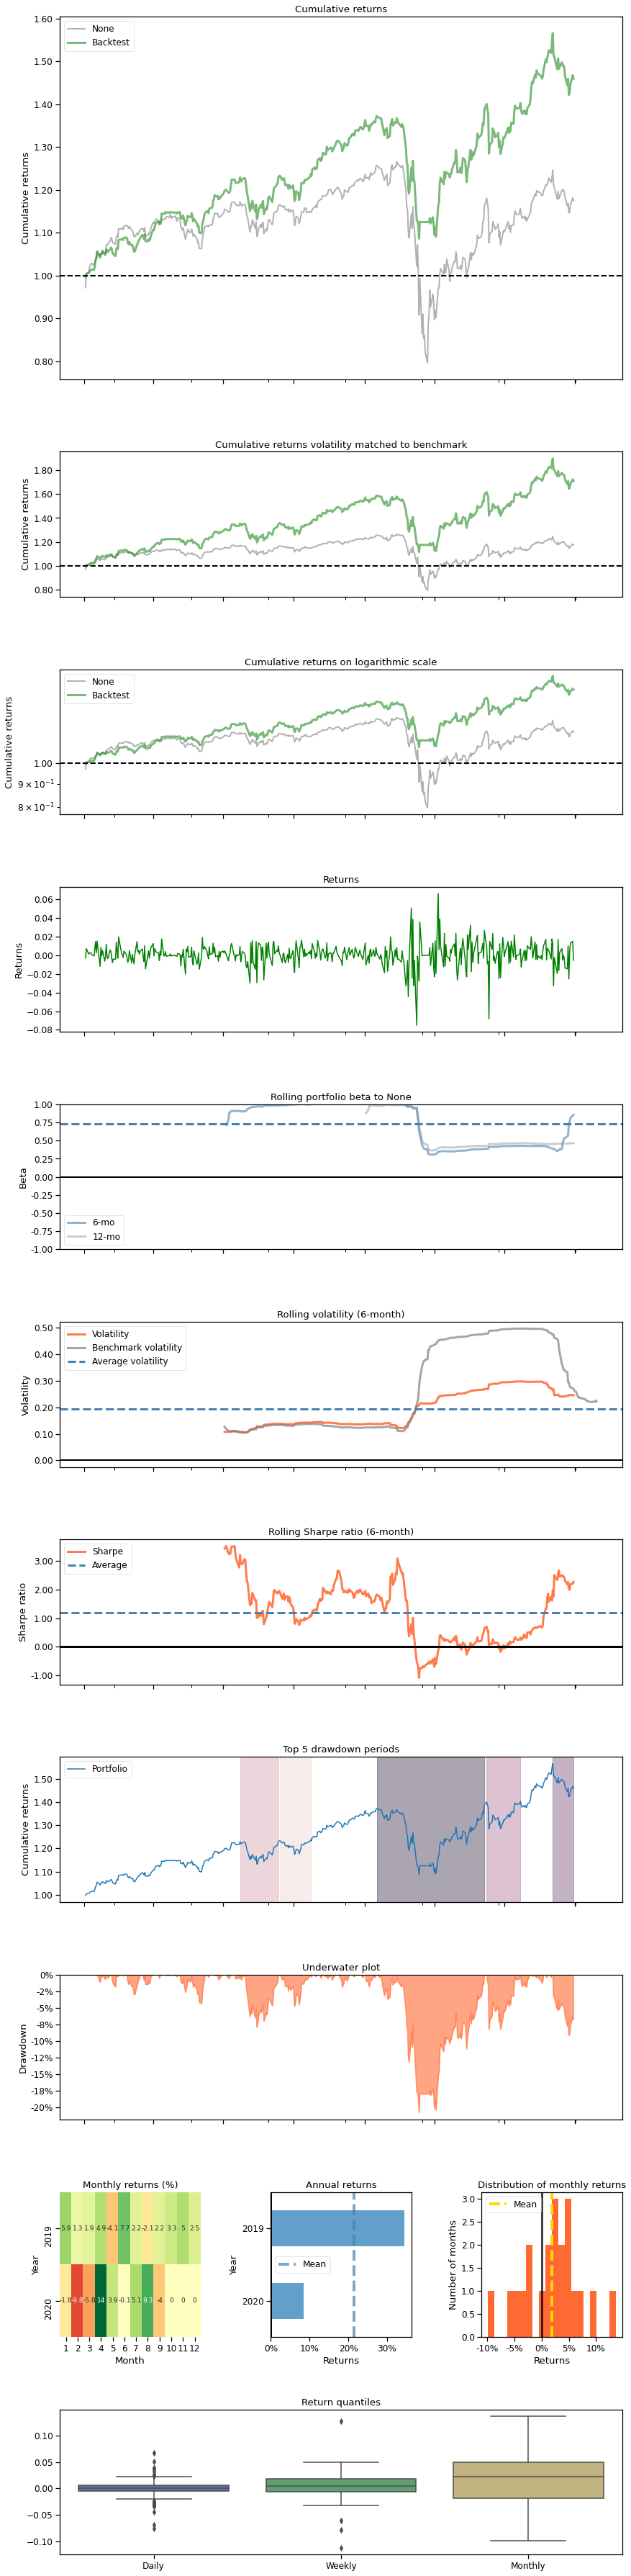

In [ ]:
%matplotlib inline
import pyfolio
df_account_value['date'] = dji['date']
df_account_value=df_account_value.dropna()
DRL_strat = backtest_strat(df_account_value)

with pyfolio.plotting.plotting_context(font_scale=1.1):
  pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                benchmark_rets=dow_strat, set_context=False)
#pyfolio_fig.savefig('returns_tear_sheet.png')